# Hierarchical Linear Regression (Sleepstudy example)

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
SEED = 7355608

In this example we are going to use **sleepstudy** dataset. It is derived from the study described in [Belenky et al. (2003)](https://pubmed.ncbi.nlm.nih.gov/12603781/) and popularized in the [lme4](https://CRAN.R-project.org/package=lme4) R package. This dataset contains the average reaction time per day (in milliseconds) on a series of tests for the most sleep-deprived group in a sleep deprivation study. The first two days of the study are considered as adaptation and training, the third day is a baseline, and sleep deprivation started after day 3. The subjects in this group were restricted to 3 hours of sleep per night.

## Load data

The **sleepstudy** dataset can be loaded using the `load_data()` function:

In [3]:
data = bmb.load_data("sleepstudy")
data

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


The response variable is `Reaction`, the average of the reaction time measurements on a given subject for a given day. The two covariates are `Days`, the number of days of sleep deprivation, and `Subject`, the identifier of the subject on which the observation was made.


## Explore data

Let's get started by displaying the data in a multi-panel layout. There's a panel for each subject in the study. This allows us to observe and compare the association of Days and Reaction between subjects.

In [4]:
def plot_data(data):
    fig, axes = plt.subplots(2, 9, figsize=(16, 7.5), sharey=True, sharex=True, dpi=300, constrained_layout=False)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)

    axes_flat = axes.ravel()

    for i, subject in enumerate(data["Subject"].unique()):
        ax = axes_flat[i]
        idx = data.index[data["Subject"] == subject].tolist()
        days = data.loc[idx, "Days"].values
        reaction = data.loc[idx, "Reaction"].values

        # Plot observed data points
        ax.scatter(days, reaction, color="C0", ec="black", alpha=0.7)

        # Add a title
        ax.set_title(f"Subject: {subject}", fontsize=14)

    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
    fig.text(0.5, 0.02, "Days", fontsize=14)
    fig.text(0.03, 0.5, "Reaction time (ms)", rotation=90, fontsize=14, va="center")

    return axes

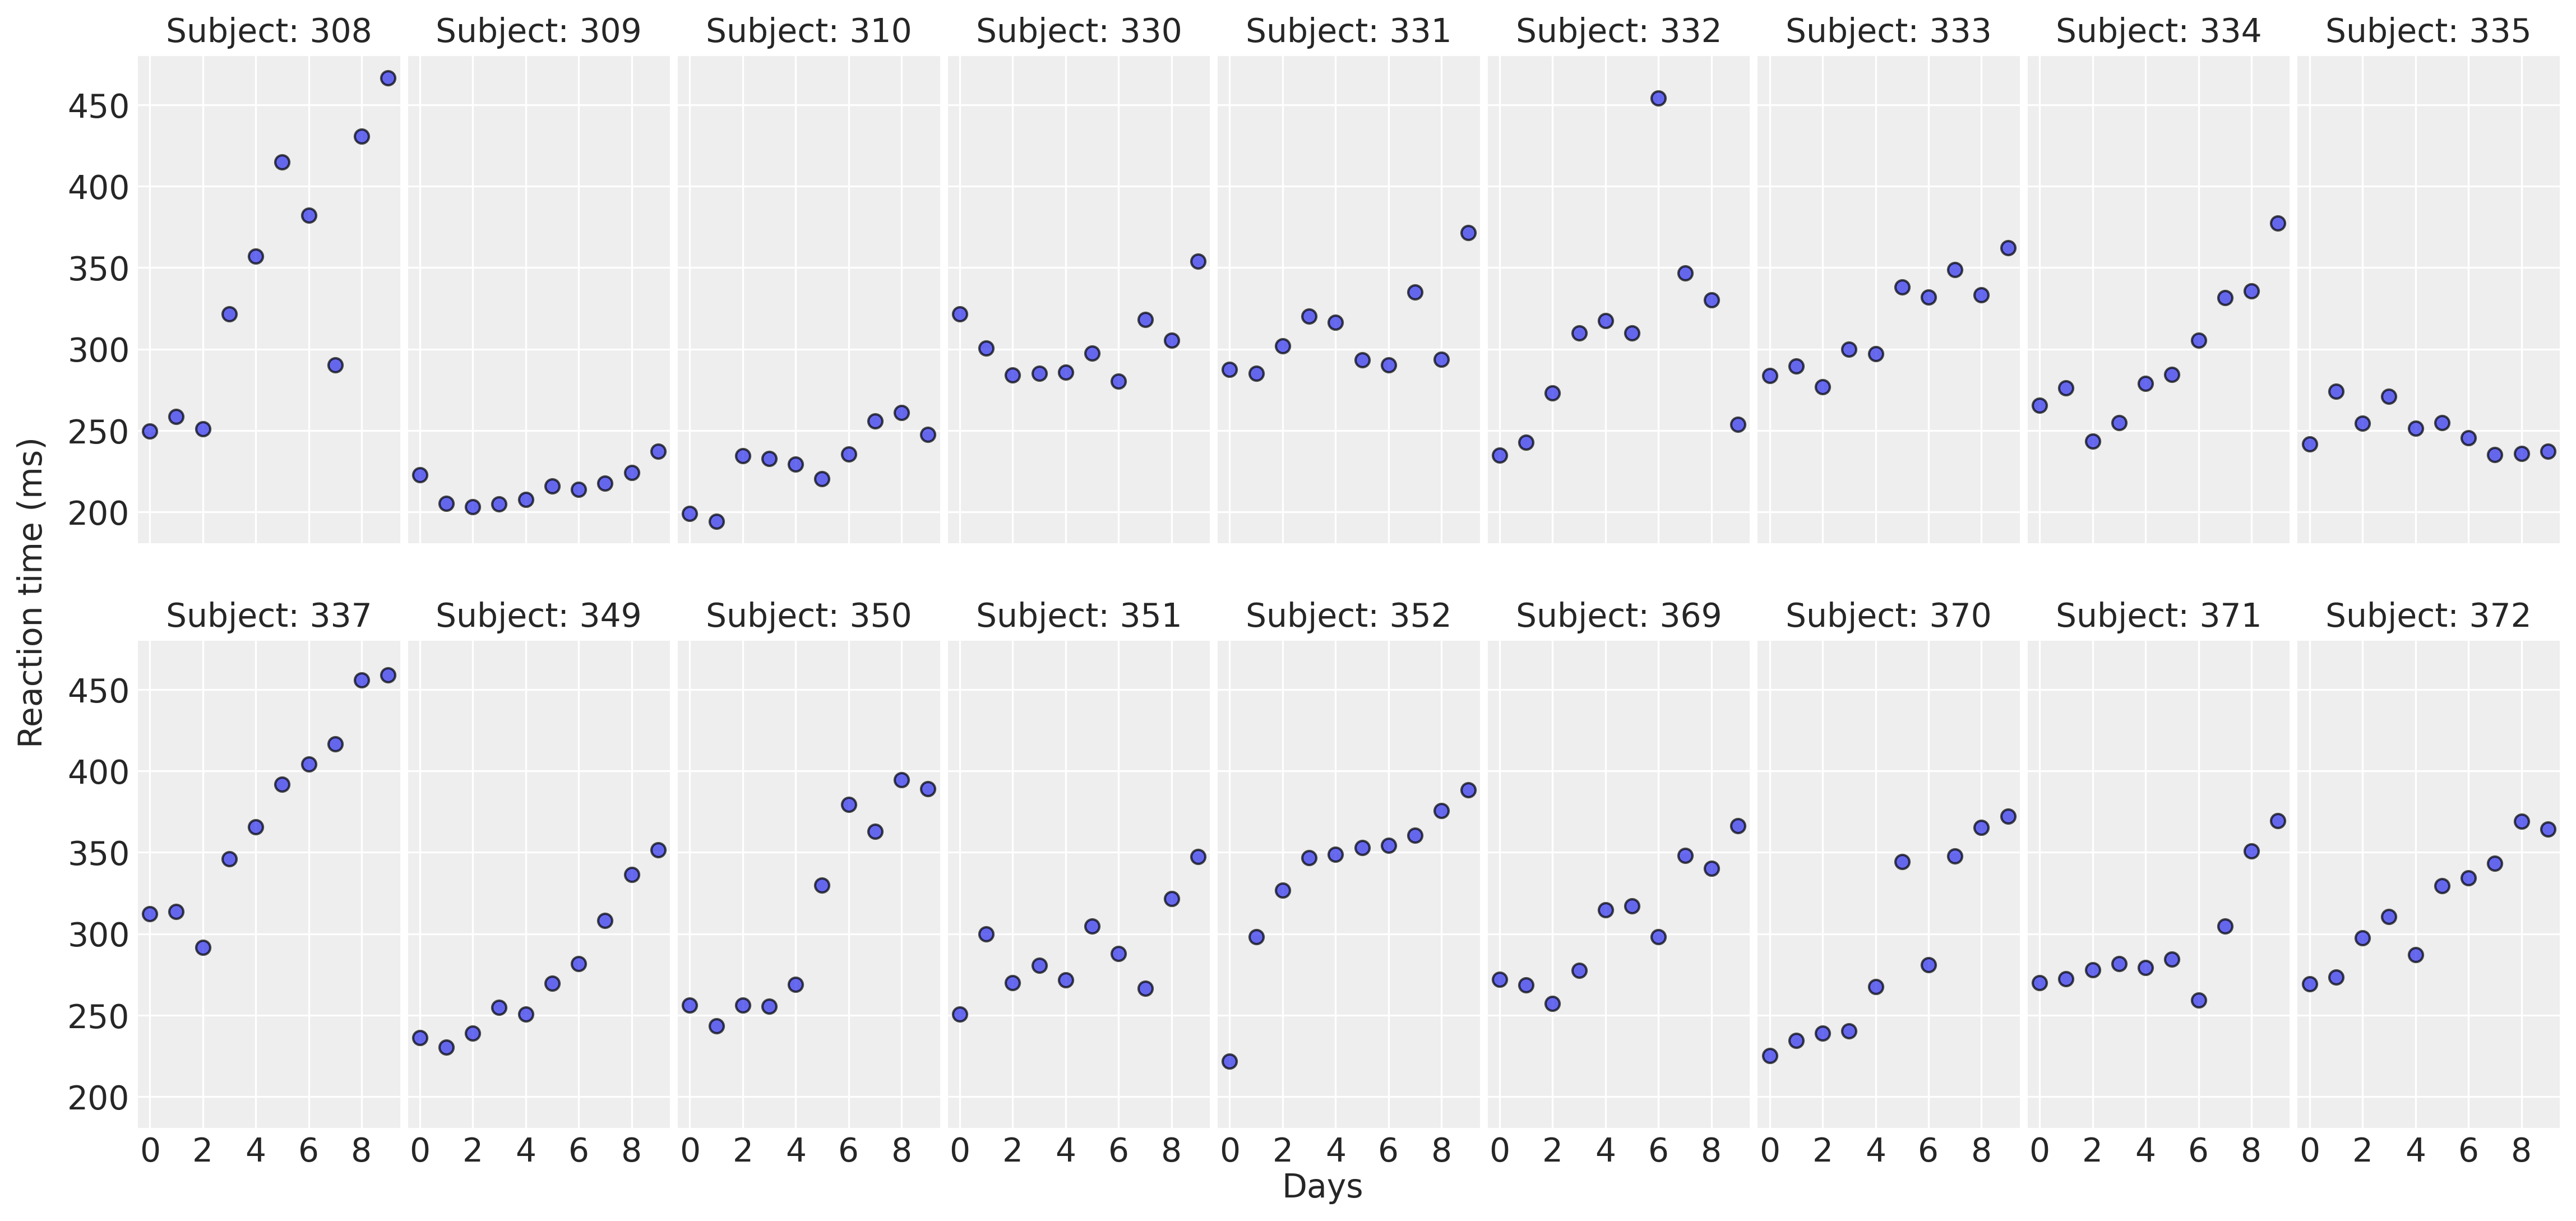

In [5]:
plot_data(data);

For most of the subjects, there's a clear positive association between Days and Reaction time. Reaction times increase as people accumulate more days of sleep deprivation. Participants differ in the initial reaction times as well as in the association between sleep deprivation and reaction time. Reaction times increase faster for some subjects and slower for others. Finally, the relationship between Days and Reaction time presents some deviations from linearity within the panels, but these are neither substantial nor systematic.

## The model

Our main goal is to measure the association between Days and Reaction times. We are interested both in the common effect across all subjects, as well as the effects associated with each individual. To do this, we're going to use a hierarchical linear regression model that includes the effect of a common intercept and slope, as well as intercepts and slopes specific to each subject. These types of effects are also known as fixed and random effects in the statistical literature.

The model can be written as follows:

$$
\begin{aligned}
\text{Reaction}_i & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \beta_{\text{Intercept}[i]} + \beta_{\text{Days}[i]}\text{Days}_i \\
\beta_{\text{Intercept}[i]} & = \beta_{\text{Intercept}} + \alpha_{\text{Intercept}_i}\\
\beta_{\text{Days}[i]} & = \beta_{\text{Days}} + \alpha_{\text{Days}_i}\\
\end{aligned}
$$

where $\beta_{\text{Intercept}}$ and $\beta_{\text{Days}}$ are the intercept and day slope effects common to all subjects in the study, and $\alpha_{\text{Intercept}_i}$ and $\alpha_{\text{Days}_i}$ are the subject-specific intercept and slope effects. These group-specific effects represent the deviation of each subject from the average behavior. 

Note we're not describing the prior distributions for $\beta_{\text{Intercept}}$, $\beta_{\text{Days}}$, $\alpha_{\text{Intercept}_i}$, $\alpha_{\text{Days}_i}$, and $\sigma$ because we're going to use default priors in Bambi.

Next, let's create the Bambi model. Here we use the formula syntax to specify the model in a clear and concise manner. The term on the left side of `~` tells `Reaction` is the response variable. The `Days` term on the right-hand side tells we want to include a slope effect for the `Days` variable common to all subjects. `(Days | Subject)` indicates the `Days` slope for a given subject is going to consist of the common slope plus a deviation specific to that subject.  The common and subject-specific intercepts are added implicitly. We could suppress them by adding a `0` on the common or the group-specific part of the formula (e.g. `0 + Days + (0 + Days|Subject)`).

If we wanted subject-specific intercepts, but not subjec-specific slopes we would have written `Reaction ~ Days + (1 | Subject)` and if we wanted slopes specific to each `Subject` without including a `Subject` specific intercept, we would write `Reaction ~ Days + (0 + Days | Subject)`.

That's been quite a long introduction for the model. Let's write it down in code now:

In [6]:
model = bmb.Model("Reaction ~ 1 + Days + (Days | Subject)", data)

A description of the model and the priors can be obtained by simply printing the `model` object

In [7]:
model

Formula: Reaction ~ 1 + Days + (Days | Subject)
Family name: Gaussian
Link: identity
Observations: 180
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 298.5079, sigma: 261.0092)
    Days ~ Normal(mu: 0.0, sigma: 48.8915)

  Group-level effects
    1|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 261.0092))
    Days|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 48.8915))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 56.1721)

There we see the formula used to specify the model, the name of the response distribution (`Gaussian`), the link function (`identity`), together with the number of observations (`180`). Below, we have a description of the prior distributions for the different terms in the model. This tells Bambi is using `Normal` priors for both common and group-specific terms, and a `HalfStudentT` distribution for the residual error term of the linear regression.

Now it's time to hit the inference button. In Bambi, it is as simple as using the `.fit()` method. This returns an `InferenceData` object from the ArviZ library. The `draws=2000` argument asks the sampler to obtain 2000 draws from the posterior for each chain.

In [8]:
idata = model.fit(draws=2000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Days, 1|Subject_sigma, 1|Subject_offset, Days|Subject_sigma, Days|Subject_offset, Reaction_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


## Analyze results

First of all, let's obtain a summary of the posterior distribution of the `Intercept` and `Days` effects. 

In [9]:
az.summary(idata, var_names=["Intercept", "Days"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,251.476,7.567,236.722,265.558
Days,10.504,1.682,7.339,13.671


On average, people's average reaction time at the beginning of the study is between 235 and 265 milliseconds. With every extra day of sleep deprivation, the mean reaction times increase, on average, between 7.2 and 13.9 milliseconds.

So far so good with the interpretation of the common effects. It's quite straightforward and simple. But this analysis would be incomplete and misleading if we don't evaluate the subject-specific terms we added to the model. These terms are telling us how much subjects differ from each other in terms of the initial reaction time and the association between days of sleep deprivation and reaction times.

Below we use ArviZ to obtain a traceplot of the subject-specific intercepts `1|Subject` and slopes `Days|Subject`. This traceplot contains two columns. On the left, we have the posterior distributions that we analyze below, and on the right, we have the draws from the posterior in the order the sampler draw them for us. The stationary random pattern, or white noise appearence, tells us the sampler converged and the chains mixed well.

From the range of the posteriors of the subject-specific intercepts we can see the initial mean reaction time for a given subject can differ substantially from the general mean we see in the table above. There's also a large difference in the slopes. Some subjects see their reaction times increase quite rapidly as they're deprived from sleep, while others have a better tolerance and get worse more slowly. Finally, from the pink posterior centered at ~ -11, there seems to be one person who gets better at reaction times. Looks like they took this as a serious challenge!

In summary, the model is capturing the behavior we saw in the data exploration stage. People differ both in the initial reaction times as well as in how these reaction times are affected by the successive days of sleep deprivation.

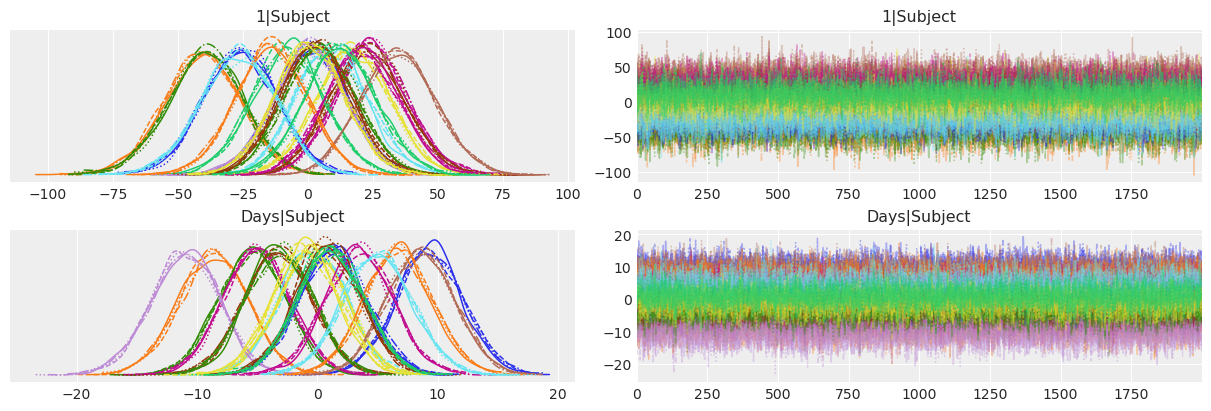

In [10]:
az.plot_trace(idata, var_names=["1|Subject", "Days|Subject"]);

So far, we've made the following conclusions

* People's mean reaction time increase as they are deprived from sleep.
* People have different reaction times in the beginning of the study.
* Some people are more affected by sleep deprivation than others.

But there's another question we haven't answered yet: Are the initial reaction times associated with how much the sleep deprivation affects the evolution of reaction times? Let's create a scatterplot to visualize the joint posterior of the subject-specific intercepts and slopes. This chart uses different colors for the individuals.

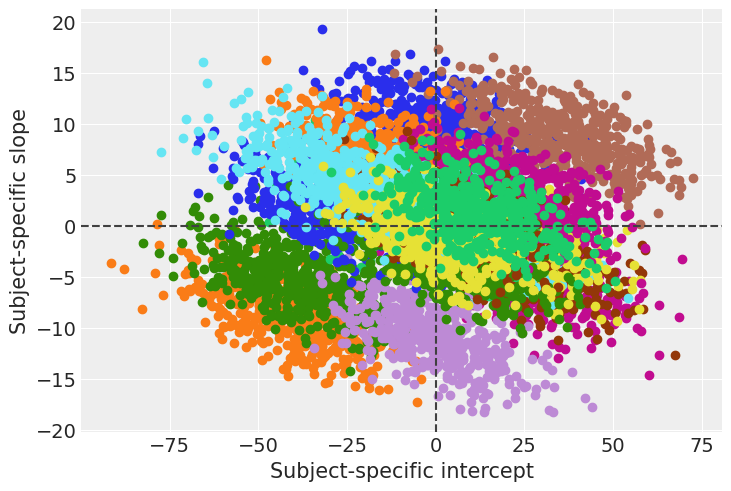

In [11]:
#  extract a subsample from the posterior and stack the chain and draw dims 
posterior = az.extract_dataset(idata, num_samples=500)

_, ax = plt.subplots()
posterior.plot.scatter("1|Subject", "Days|Subject",
                       hue="Subject__factor_dim",
                       add_guide=False,
                       ax=ax)

ax.axhline(c="0.25", ls="--")
ax.axvline(c="0.25", ls="--")
ax.set_xlabel("Subject-specific intercept")
ax.set_ylabel("Subject-specific slope");

If we look at the bigger picture, i.e omitting the groups, we can conclude there's no association between the intercept and slope. In other words, having lower or higher intial reaction times does not say anything about how much sleep deprivation affects the average reaction time on a given subject.

On the other hand, if we look at the joint posterior for a given individual, we can see a negative correlation between the intercept and the slope. This is telling that, conditional on a given subject, the intercept and slope posteriors are not independent. However, it doesn't imply anything about the overall relationship between the intercept and the slope, which is what we need if we want to know whether the initial time is associated with how much sleep deprivation affects the reaction time.

To conclude with this example, we're going create the same plot we created in the beginning with the mean regression lines and a credible bands for them.

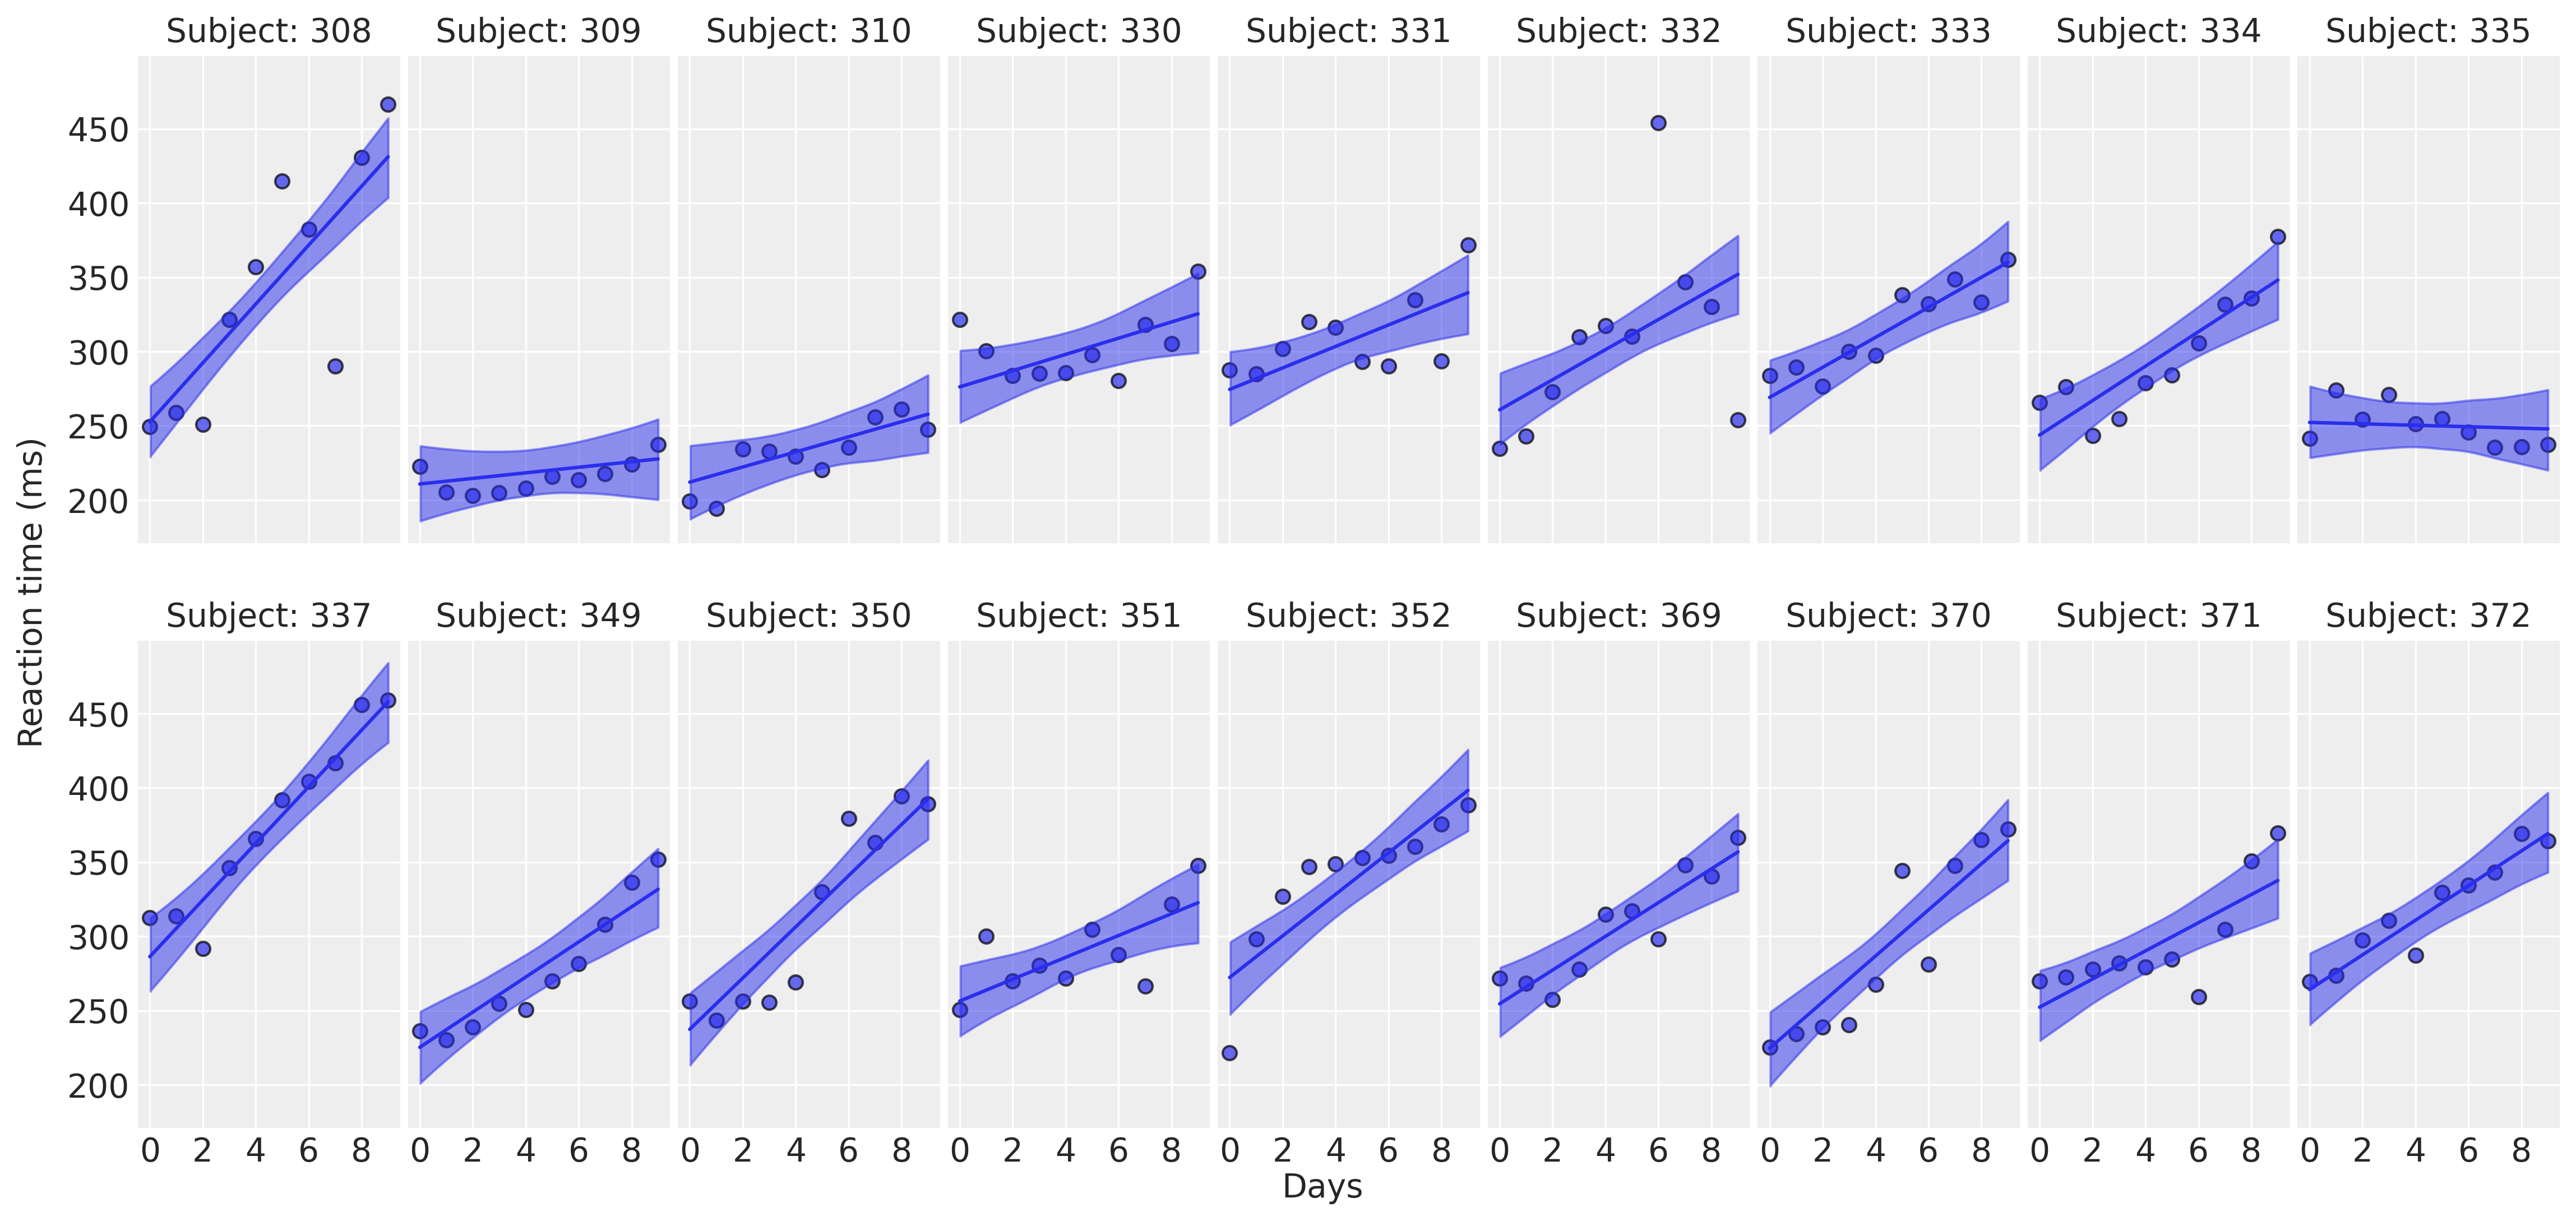

In [12]:
# Obtain the posterior of the mean
model.predict(idata)

# Plot the data
axes = plot_data(data)


# Take the posterior of the mean reaction time
reaction_mean = az.extract_dataset(idata)["Reaction_mean"].values

for subject, ax in zip(data["Subject"].unique(), axes.ravel()):

    idx = data.index[data["Subject"]== subject].tolist()
    days = data.loc[idx, "Days"].values
    
    # Plot highest density interval / credibility interval
    az.plot_hdi(days, reaction_mean[idx].T[np.newaxis], color="C0", ax=ax)
    
    # Plot mean regression line
    ax.plot(days, reaction_mean[idx].mean(axis=1), color="C0")

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jun 20 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.3.0

pandas    : 1.4.2
numpy     : 1.21.5
matplotlib: 3.5.1
sys       : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
bambi     : 0.9.0
arviz     : 0.13.0.dev0

Watermark: 2.3.0

